In [1]:
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import matplotlib as mpl

In [2]:
realisation = 'ssp585'

In [3]:
df_regions = pd.read_csv('/Users/amosm1/Desktop/ar6_regions.csv', header=None)

In [4]:
#-180 -> 180
regions = dict()

for line in df_regions.to_numpy():
    points = line[4:]
    new_points = []
    for point in points:
        if point in ['\\', 'nan', np.nan]:
            continue
        else:
            lon_point = float(point.strip('}').split('|')[0])# % 360
            lat_point = float(point.strip('}').split('|')[1])
            new_points.append([lon_point,lat_point])
    regions[line[2]] = new_points

In [5]:
region_names = list(regions.keys())

In [6]:
ds = xr.open_dataset('/Users/amosm1/Desktop/MMM_{}_anomaly_surface_temperature.nc'.format(realisation))
ds.rio.write_crs("wgs1984", inplace=True)
da = ds['unknown']
da = da.resample(time='1Y').mean('time', skipna=True)
da.rio.write_crs("wgs1984", inplace=True)
da.rio.set_crs("wgs1984", inplace=True)

da = da.reindex(latitude=np.arange(-90,90,1), longitude=np.arange(0,360, 1), method='nearest')
da.rio.set_crs("wgs1984", inplace=True)
da.rio.write_crs("wgs1984", inplace=True)
da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180)).sortby('longitude')

In [7]:
df_output = pd.DataFrame()

In [8]:
df_output['time'] = da.time.data

In [9]:
for region in region_names:
    points = regions[region]
    geometries = [
    {
        'type': 'Polygon',
        'coordinates': [points],
        'crs': "wgs1984"
    }
    ]
    try:
        clipped = da.rio.clip(geometries, da.rio.crs, drop=False, all_touched=True)
#         print(region)
#         clipped[0].plot()
#         plt.show()
    except:
        print('Np')

    df_output[region] = clipped.mean(['longitude', 'latitude'], skipna=True)
# plt.show()

In [10]:
df_output.set_index('time', inplace=True)

In [11]:
df_output.to_csv('Area_region_MST_{}.csv'.format(realisation))

In [10]:
def make_warming_stripe(region):
    points = np.asarray(regions[region])
    temp_time_series = df_output[region]
    lons = points[:, 0]
    max_lon = np.max(lons)
    min_lon = np.min(lons)

    # make data array
    new_lon = np.arange(min_lon, max_lon, (max_lon - min_lon)/204)
    new_lat = np.arange(-90,90,0.1)

    stripe_data = np.ones((len(new_lat), len(new_lon))) * np.nan
    for i in range(204):
        stripe_data[:, i] = len(new_lat) * [temp_time_series[i]]

    temp_da = xr.DataArray(stripe_data,coords=[('latitude', new_lat), ('longitude', new_lon)])
    temp_da.rio.set_crs("wgs1984", inplace=True)
    temp_da.rio.write_crs("wgs1984", inplace=True)

    geometries = [
    {
        'type': 'Polygon',
        'coordinates': [points],
        'crs': "wgs1984"
    }
    ]
    clipped = temp_da.rio.clip(geometries, temp_da.rio.crs, drop=False)
    divnorm = mpl.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=7)
    plt.pcolormesh(new_lon, new_lat, clipped, cmap=plt.cm.bwr, vmin=-1, vmax=7, norm=divnorm)
    return

In [16]:
def make_single_color(region, time=0):
    points = np.asarray(regions[region])
    temp_time_series = df_output[region]
    lons = points[:, 0]
    max_lon = np.max(lons)
    min_lon = np.min(lons)

    # make data array
    new_lon = np.arange(min_lon, max_lon, (max_lon - min_lon)/204)
    new_lat = np.arange(-90,90,0.1)

    stripe_data = np.ones((len(new_lat), len(new_lon))) * temp_time_series[time]
#     for i in range(204):
#         stripe_data[:, i] = len(new_lat) * [temp_time_series[i]]

    temp_da = xr.DataArray(stripe_data,coords=[('latitude', new_lat), ('longitude', new_lon)])
    temp_da.rio.set_crs("wgs1984", inplace=True)
    temp_da.rio.write_crs("wgs1984", inplace=True)

    geometries = [
    {
        'type': 'Polygon',
        'coordinates': [points],
        'crs': "wgs1984"
    }
    ]
    clipped = temp_da.rio.clip(geometries, temp_da.rio.crs, drop=False)
    divnorm = mpl.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=7)
    plt.pcolormesh(new_lon, new_lat, clipped, cmap=plt.cm.bwr, vmin=-1, vmax=7, norm=divnorm)
    return

/Users/amosm1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/amosm1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


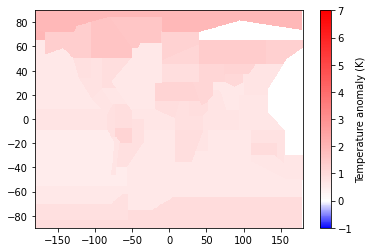

In [21]:
for r in region_names:
    make_single_color(r, time=-100)
plt.colorbar(label='Temperature anomaly (K)')
plt.show()

/Users/amosm1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/amosm1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


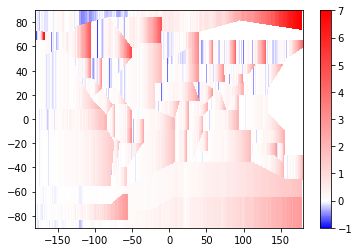

In [15]:
for r in region_names:
    make_warming_stripe(r)
plt.colorbar(label='Temperature anomaly (K)')
plt.show()

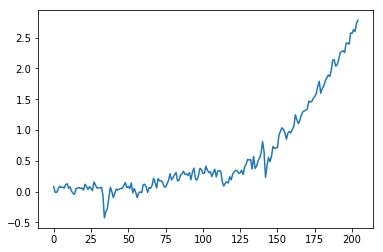

In [105]:
plt.plot(df_output[region_names[10]])

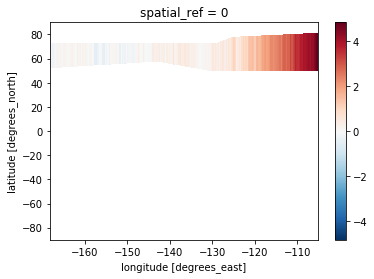

In [89]:
points = np.asarray(regions[region_names[1]])
temp_time_series = df_output[region_names[1]]
lons = points[:, 0]
max_lon = np.max(lons)
min_lon = np.min(lons)

# make data array
new_lon = np.arange(min_lon, max_lon, (max_lon - min_lon)/204)
new_lat = np.arange(-90,90,0.1)

stripe_data = np.ones((len(new_lat), len(new_lon))) * np.nan
for i in range(204):
    stripe_data[:, i] = len(new_lat) * [temp_time_series[i]]

temp_da = xr.DataArray(stripe_data,coords=[('latitude', new_lat), ('longitude', new_lon)])
temp_da.rio.set_crs("wgs1984", inplace=True)
temp_da.rio.write_crs("wgs1984", inplace=True)

geometries = [
{
    'type': 'Polygon',
    'coordinates': [points],
    'crs': "wgs1984"
}
]
clipped = temp_da.rio.clip(geometries, temp_da.rio.crs, drop=False)
clipped.plot()

In [85]:
stripe_data.shape

(1800, 204)

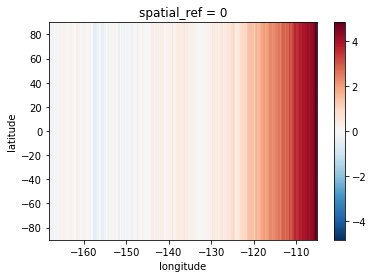

In [87]:
temp_da.plot()

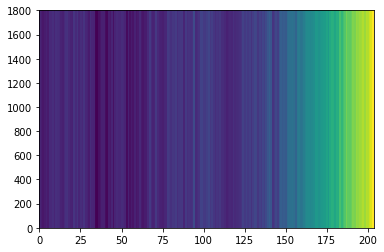

In [83]:
plt.pcolormesh(stripe_data)

In [77]:
stripe_data[:, 0].shape

(1800,)

In [79]:
len(len(new_lat) * [temp_time_series[i]])

1800

In [41]:
temp_da

<xarray.DataArray (longitude: 204, latitude: 18)>
array([[ 0.003648,  0.003648,  0.003648, ...,  0.003648,  0.003648,  0.003648],
       [-0.00417 , -0.00417 , -0.00417 , ..., -0.00417 , -0.00417 , -0.00417 ],
       [ 0.012373,  0.012373,  0.012373, ...,  0.012373,  0.012373,  0.012373],
       ...,
       [ 1.695268,  1.695268,  1.695268, ...,  1.695268,  1.695268,  1.695268],
       [ 1.723001,  1.723001,  1.723001, ...,  1.723001,  1.723001,  1.723001],
       [ 1.753712,  1.753712,  1.753712, ...,  1.753712,  1.753712,  1.753712]])
Coordinates:
  * longitude  (longitude) float64 -180.0 -178.2 -176.5 ... 174.7 176.5 178.2
  * latitude   (latitude) int64 -90 -80 -70 -60 -50 -40 ... 30 40 50 60 70 80

In [39]:
temp_da

<xarray.DataArray (dim_0: 204, dim_1: 18)>
array([[ 0.003648,  0.003648,  0.003648, ...,  0.003648,  0.003648,  0.003648],
       [-0.00417 , -0.00417 , -0.00417 , ..., -0.00417 , -0.00417 , -0.00417 ],
       [ 0.012373,  0.012373,  0.012373, ...,  0.012373,  0.012373,  0.012373],
       ...,
       [ 1.695268,  1.695268,  1.695268, ...,  1.695268,  1.695268,  1.695268],
       [ 1.723001,  1.723001,  1.723001, ...,  1.723001,  1.723001,  1.723001],
       [ 1.753712,  1.753712,  1.753712, ...,  1.753712,  1.753712,  1.753712]])
Dimensions without coordinates: dim_0, dim_1

In [ ]:
for region in region_names:
    points = regions[region]
    lons = points[:, 0]
    max_lon = np.max(lons)
    max_lon = np.max(lons)
    
    
    geometries = [
    {
        'type': 'Polygon',
        'coordinates': [points],
        'crs': "wgs1984"
    }
    ]
    try:
        clipped = da.rio.clip(geometries, da.rio.crs, drop=False, all_touched=True)
        print(region)
        clipped[0].plot()
        plt.show()
    except:
        print('Np')

    df_output[region] = clipped.mean(['longitude', 'latitude'], skipna=True)
# plt.show()

In [37]:
df_output.to_csv('Area_region_MST.csv')

In [118]:
da.time

<xarray.DataArray 'time' (time: 251)>
array([cftime.DatetimeNoLeap(1850, 12, 31, 0, 0, 0, 0, 2, 365),
       cftime.DatetimeNoLeap(1851, 12, 31, 0, 0, 0, 0, 3, 365),
       cftime.DatetimeNoLeap(1852, 12, 31, 0, 0, 0, 0, 4, 365), ...,
       cftime.DatetimeNoLeap(2098, 12, 31, 0, 0, 0, 0, 5, 365),
       cftime.DatetimeNoLeap(2099, 12, 31, 0, 0, 0, 0, 6, 365),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, 0, 365)], dtype=object)
Coordinates:
  * time         (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    spatial_ref  int64 0

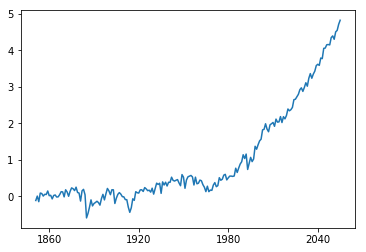

In [120]:
plt.plot(da.time, df_output['Greenland/Iceland'])

In [24]:
import ipywidgets as widgets
from IPython.display import display

w = widgets.Dropdown(
    options=df_output.columns,
    description='Task:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

w.observe(on_change)

display(w)

Dropdown(description='Task:', options=('Greenland/Iceland', 'N.W.North-America', 'N.E.North-America', 'W.North…

Dropdown(description='Region', options=('Greenland/Iceland', 'N.W.North-America', 'N.E.North-America', 'W.Nort…

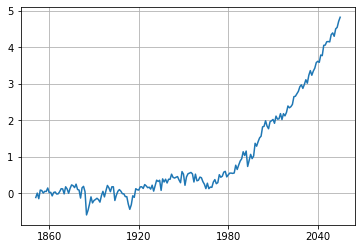

In [36]:
x = np.linspace(0, 2 * np.pi, 100)
 
fig, ax = plt.subplots()
line, = ax.plot(df_output[df_output.columns[0]])
ax.grid(True)
 
def update(change):
    line.set_ydata(change.new)
    fig.canvas.draw()
     
        
w = widgets.Dropdown(
    options=df_output.columns,
    description='Region',
)

w.observe(update, 'option')
w

In [64]:
from ipywidgets import interact

In [84]:
df_output.shape

(251, 58)

In [87]:

@interact
def scatter_plot(y=list(df_output.columns)):
    
    df_output.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
             text='title',
             title=f'{y.title()} vs {x.title()}')

interactive(children=(Dropdown(description='y', options=('Greenland/Iceland', 'N.W.North-America', 'N.E.North-…

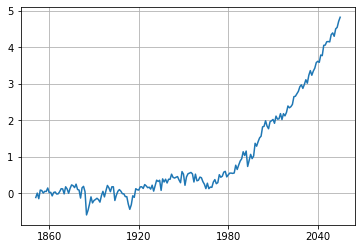

interactive(children=(Dropdown(description='column', options=('Greenland/Iceland', 'N.W.North-America', 'N.E.N…

In [68]:
fig, ax = plt.subplots()
line, = ax.plot(df_output[df_output.columns[0]])
ax.grid(True)

@interact
def show_articles_more_than(column=option_list):
    line.set_ydata(df_output[column])
    fig.canvas.draw()

Dropdown(description='Region:', options=('Greenland/Iceland', 'N.W.North-America', 'N.E.North-America', 'W.Nor…

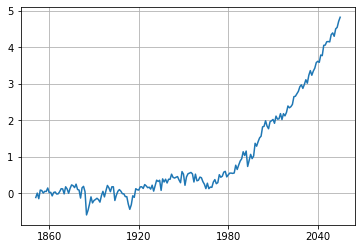

In [62]:
from IPython.display import display
from ipywidgets import Dropdown

fig, ax = plt.subplots()
line, = ax.plot(df_output[df_output.columns[0]])
ax.grid(True)

def dropdown_eventhandler(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        line.set_ydata(change.new)
        fig.canvas.draw()

option_list = list(df_output.columns.values)
dropdown = Dropdown(description="Region:", options=option_list, value='Greenland/Iceland')
dropdown.observe(dropdown_eventhandler)
display(dropdown)

In [53]:
change

NameError: name 'change' is not defined

/Users/amosm1/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


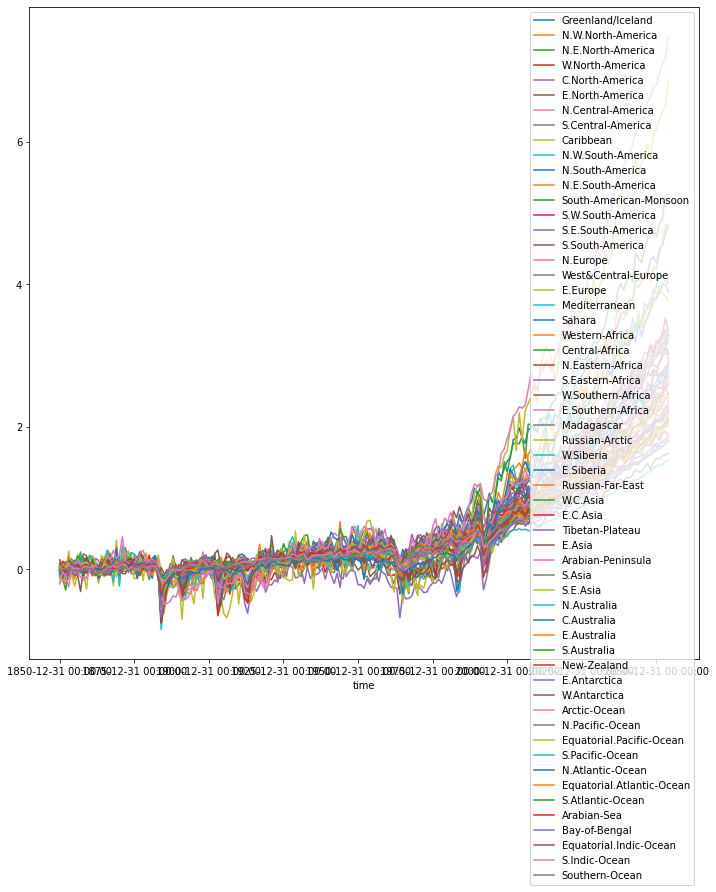

In [29]:

df_output.plot(figsize=(12,12))
plt.show()